In [1]:
import numpy as np 
from pandas import Series, DataFrame
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import catboost

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
#original catalog
path = r'C:\Users\pedro\OneDrive - Universidade do Porto\Imagens\OneDrive - Universidade do Porto\Ambiente de Trabalho\UNI\Mestrado\1º semestre\Machine Learning\Projeto\dados\catalog.parquet'
catalog = pd.read_parquet(path)

In [3]:
catalog

,ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,1,150.477592,2.328928,14051.033584,24912.034028,0.019432,1.154464e-02,150.477638,2.328963,b'181_32',...,-9.140639,-9.116661,-9.089199,-9.063887,-9.050062,0.038461,0.038461,0.038461,0.038461,0.038461
1,2,150.477978,2.329170,14041.782916,24917.839703,0.102373,1.305541e-01,150.477974,2.329169,b'181_33',...,-8.737532,-8.618159,-8.478306,-8.337237,-8.213281,0.018737,0.018737,0.018737,0.018737,0.018737
2,3,150.477024,2.329483,NaN,NaN,NaN,NaN,150.477111,2.329667,b'181_34',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,150.477312,2.330573,14057.758498,24951.520772,0.098902,9.468231e-02,150.477316,2.330574,b'181_38',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,150.474793,2.332136,14118.162336,24989.006449,0.017773,3.539389e-02,150.474843,2.332179,b'181_39',...,-7.940726,-7.940726,-7.940726,-7.940726,-7.940726,0.042471,0.042471,0.042471,0.042471,0.042471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964501,964502,150.068793,2.870516,23853.815263,37909.784856,0.000065,8.288924e-05,150.068801,2.870500,b'283_5270',...,-9.524284,-9.095250,-8.751433,-8.005345,-8.005345,1.873661,1.873661,1.873661,1.873661,1.873661
964502,964503,150.072295,2.871735,23769.881726,37939.037182,0.000001,4.420735e-06,150.072305,2.871736,b'283_5271',...,-7.940726,-7.940726,-7.940726,-7.940726,-7.940726,1.129562,1.232992,1.334211,1.445236,1.543489
964503,964504,150.071539,2.874151,23787.988894,37997.043844,0.000004,6.963900e-07,150.071549,2.874164,b'283_5272',...,-10.023261,-9.878627,-9.719501,-9.560150,-9.434907,0.769145,0.817205,0.953520,1.319708,1.572936
964504,964505,150.088646,2.876782,23377.925486,38060.183349,0.098302,2.854818e-02,150.088643,2.876837,b'283_5273',...,-9.503490,-9.411257,-9.333571,-9.192708,-9.077335,0.042147,0.042147,0.042147,0.042147,0.042147


In [4]:
# new catalog
# filter out unreliable observations
cata = catalog[catalog.filter(like='FLAG').eq(0).all(axis=1)] 

In [5]:
features = ['lp_zBEST']
for col_name in list(cata.columns.values):
        if 'MAG' in col_name: 
            features.append(col_name)

# List of labels
labels =['lp_mass_best','lp_SFR_best']

#choose only data from galaxies
cata = cata[cata['lp_type'] == 0] 

# labels range 
cata = cata.loc[(cata['lp_zBEST'] > 0.2) & (cata['lp_zBEST'] < 5.5)]  
cata = cata.loc[(cata['lp_SFR_best'] > -4) & (cata['lp_SFR_best'] < 3)]  

# new catalog
columns = features + labels
cat = cata[columns]

In [6]:
cat = cat.dropna(subset=labels)  # Drop NaN in targets' columns

#final table
cat = cat.loc[cat.index] 

In [7]:
cat

,lp_zBEST,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,HSC_g_MAG,HSC_g_MAGERR,HSC_r_MAG,HSC_r_MAGERR,HSC_i_MAG,...,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ACS_F814W_MAG,ACS_F814W_MAGERR,lp_mass_best,lp_SFR_best
0,1.5930,26.089124,0.034136,26.013149,0.027118,26.002327,0.026108,25.887478,0.032539,25.977980,...,25.135260,0.105391,NaN,NaN,NaN,NaN,25.791597,0.159766,8.52185,0.2347
4,2.8698,26.614236,0.054797,26.686707,0.050745,25.923896,0.023349,25.797231,0.030013,25.991617,...,25.417095,0.206961,NaN,NaN,NaN,NaN,26.037453,0.105512,8.05107,0.4251
5,1.5139,27.835780,0.169823,28.148341,0.193865,28.088120,0.171603,27.633024,0.160903,27.650674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.06661,-1.1460
11,0.7070,24.957998,0.017385,25.043569,0.015100,24.967641,0.013929,24.509829,0.012705,23.990104,...,24.229948,0.175698,NaN,NaN,NaN,NaN,24.015520,0.074395,8.64422,-0.1711
16,0.5725,26.670439,0.057265,26.522136,0.042355,26.656828,0.045123,26.665598,0.065118,26.635781,...,NaN,NaN,NaN,NaN,NaN,NaN,27.016584,0.254684,6.69292,-0.6479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964428,0.5593,23.623760,0.004034,NaN,NaN,23.604851,0.002866,23.406177,0.003119,23.248782,...,22.292629,0.025234,23.056145,1.297706,NaN,NaN,23.032091,0.015964,7.93811,0.1261
964436,1.7660,26.549842,0.067882,NaN,NaN,NaN,NaN,NaN,NaN,24.378633,...,20.503550,0.011555,21.200373,0.252214,21.45981,0.457638,23.381042,0.030234,11.23245,-0.3316
964438,0.3207,26.158828,0.044645,NaN,NaN,25.315184,0.022614,24.806737,0.010618,24.591523,...,24.152298,0.059791,NaN,NaN,NaN,NaN,24.089319,0.038112,7.47894,-1.7330
964440,0.8165,26.879697,0.050111,NaN,NaN,26.704352,0.045443,NaN,NaN,25.143741,...,24.134888,0.067892,NaN,NaN,NaN,NaN,24.736200,0.052431,7.63867,-0.7851


In [8]:
X = cat[features] #features matrix
y = cat[labels]  #labels matrix

In [20]:
labels =['lp_mass_best','lp_SFR_best']
columns_df = ['lightgbm', 'catboost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

models = [
    LGBMRegressor(
        objective='regression', 
        n_jobs=-1,
        n_estimators=1000,
        max_depth=8,
        subsample=0.8,
        verbosity=-1
    ),
    CatBoostRegressor(
        loss_function='RMSE',   
        logging_level='Silent',
        n_estimators=1000,
        max_depth=8
    )
]

pred_dict = {}

for i, method in enumerate(models):
    model_name = columns_df[i]
    print(f"\nTraining {model_name}...")

    start_time = time.time()

    regressor = MultiOutputRegressor(method)
    regressor.fit(X_train, y_train)
    pred = regressor.predict(X_val)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Execution time for {model_name}: {execution_time:.2f} seconds")

    for j, label in enumerate(labels):
        col_name = model_name + '_' + label
        pred_dict[col_name] = pred[:, j]

pred_df = pd.DataFrame(pred_dict, index=y_val.index)


Training lightgbm...
Execution time for lightgbm: 32.91 seconds

Training catboost...
Execution time for catboost: 113.26 seconds


In [10]:
pred_df

,lightgbm_lp_mass_best,lightgbm_lp_SFR_best,catboost_lp_mass_best,catboost_lp_SFR_best
656880,8.035346,0.599367,8.073039,0.614131
335181,8.426536,0.146881,8.528642,0.179652
592173,8.526834,0.280309,8.598197,0.294318
299809,6.882304,-0.410455,6.944348,-0.213438
742872,6.827555,-2.963858,6.801227,-2.685728
...,...,...,...,...
558720,7.255597,-0.237730,7.199897,-0.220057
137258,10.026905,1.303851,9.958681,1.314273
742768,8.880355,0.524515,9.060972,0.696748
460791,6.400661,-1.178234,6.511541,-1.034031


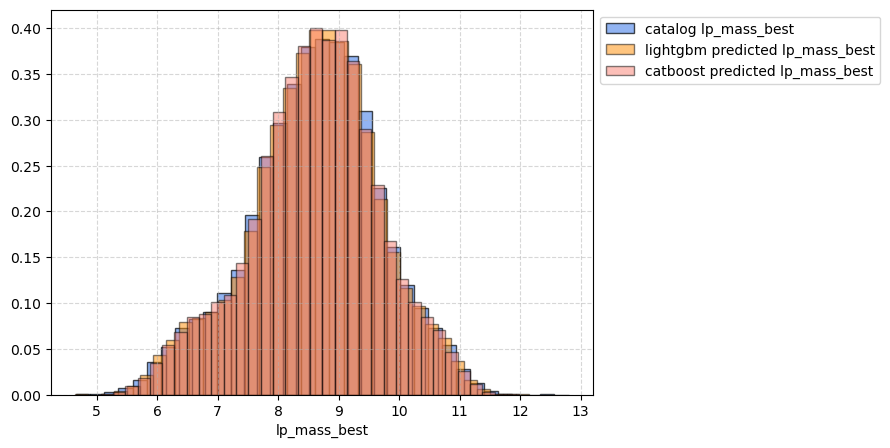

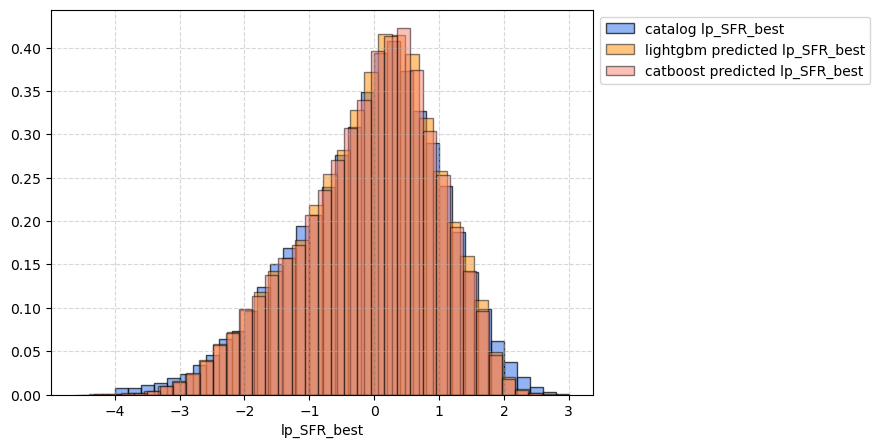

In [11]:
colors = ['cornflowerblue', 'darkorange', 'salmon']

for i, label in enumerate(labels):
    fig_hist, ax = plt.subplots(figsize=(7, 5))
    ax.hist(y_val[label], 35, facecolor=colors[0], edgecolor='black', alpha=0.7, label='catalog {}'.format(label), density=True)
    ax.hist(pred_df['lightgbm_{}'.format(label)], 35, facecolor=colors[1], edgecolor='black', alpha=0.5, label='lightgbm predicted {}'.format(label), density=True)
    ax.hist(pred_df['catboost_{}'.format(label)], 35, facecolor=colors[2], edgecolor='black', alpha=0.5, label='catboost predicted {}'.format(label), density=True)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel(label)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
    plt.show()

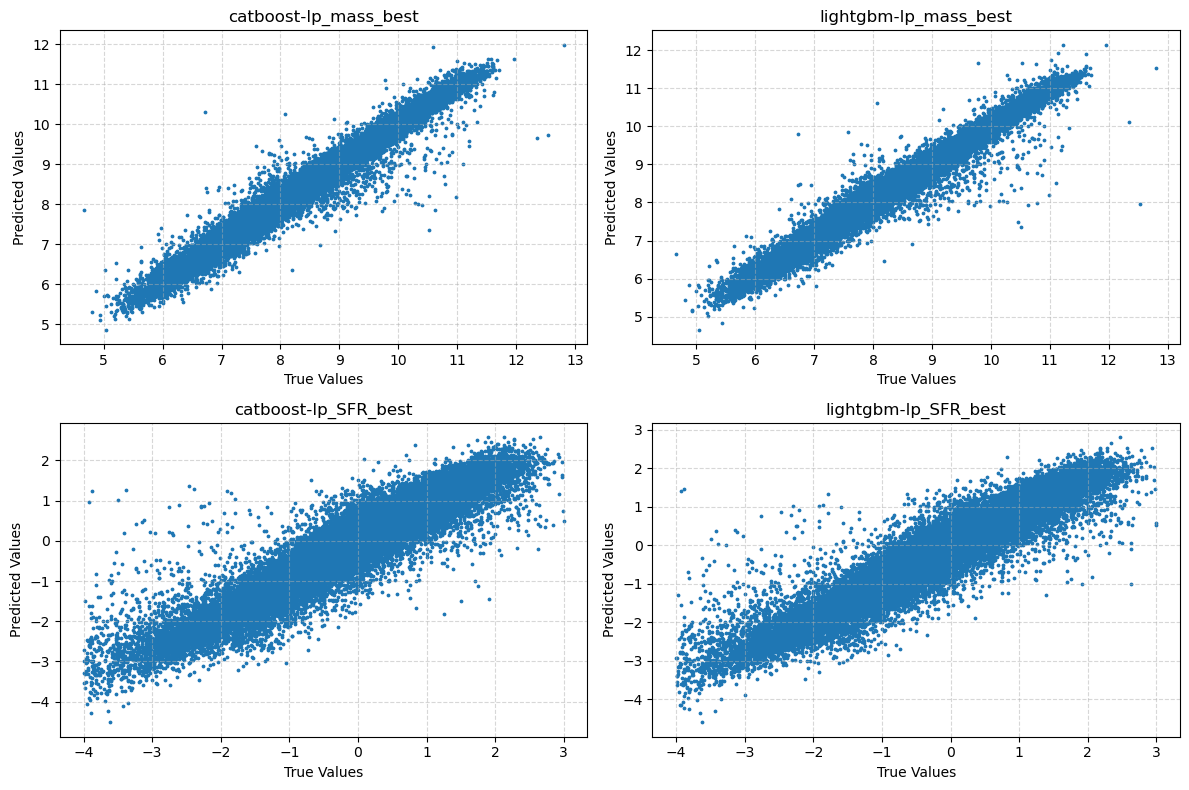

In [12]:
models = ['catboost', 'lightgbm']

fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3
        axes[i, j].scatter(y_val[label], pred_df['{}_{}'.format(model, label)], s=marker_size)
        
        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

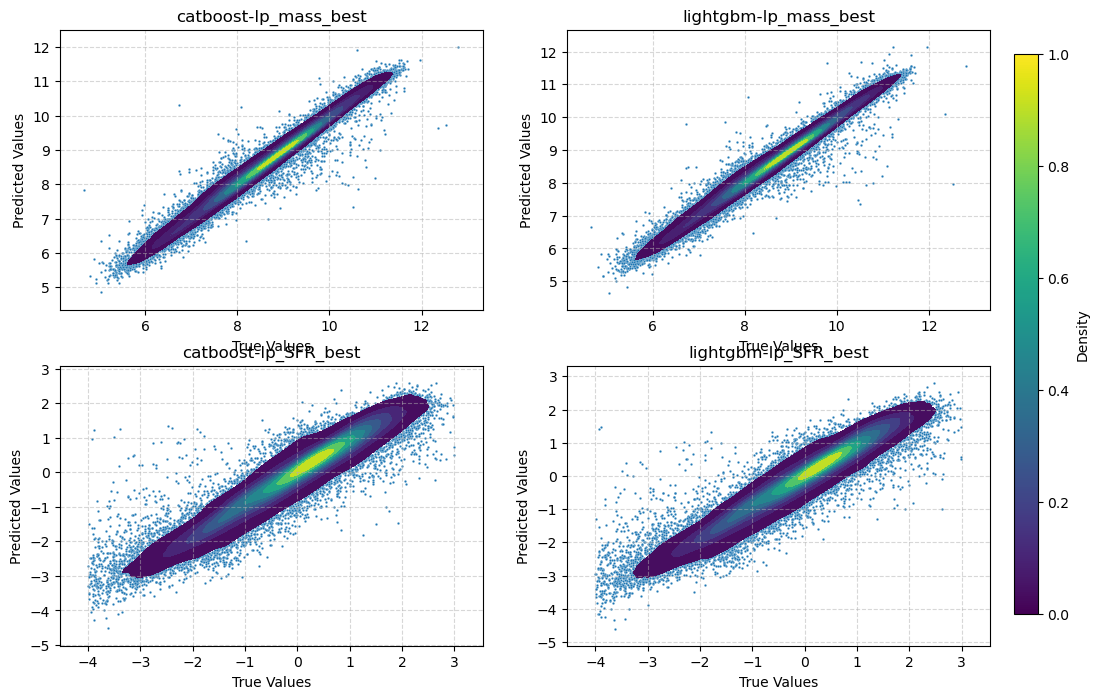

In [13]:
models = ['catboost', 'lightgbm']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3
        
        # Create a scatter plot with color-coded density
        scatter = sns.scatterplot(x=y_val[label], y=pred_df['{}_{}'.format(model, label)], ax=axes[i, j], s=marker_size)
        kde = sns.kdeplot(x=y_val[label], y=pred_df['{}_{}'.format(model, label)], ax=axes[i, j], cmap="viridis", fill=True, levels=10)

        axes[i, j].grid(True, linestyle='--', alpha=0.5)
        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Predicted Values')
        
# Create a colorbar outside the subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])

# Add the colorbar directly from the ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Density')


#plt.tight_layout()
plt.show()

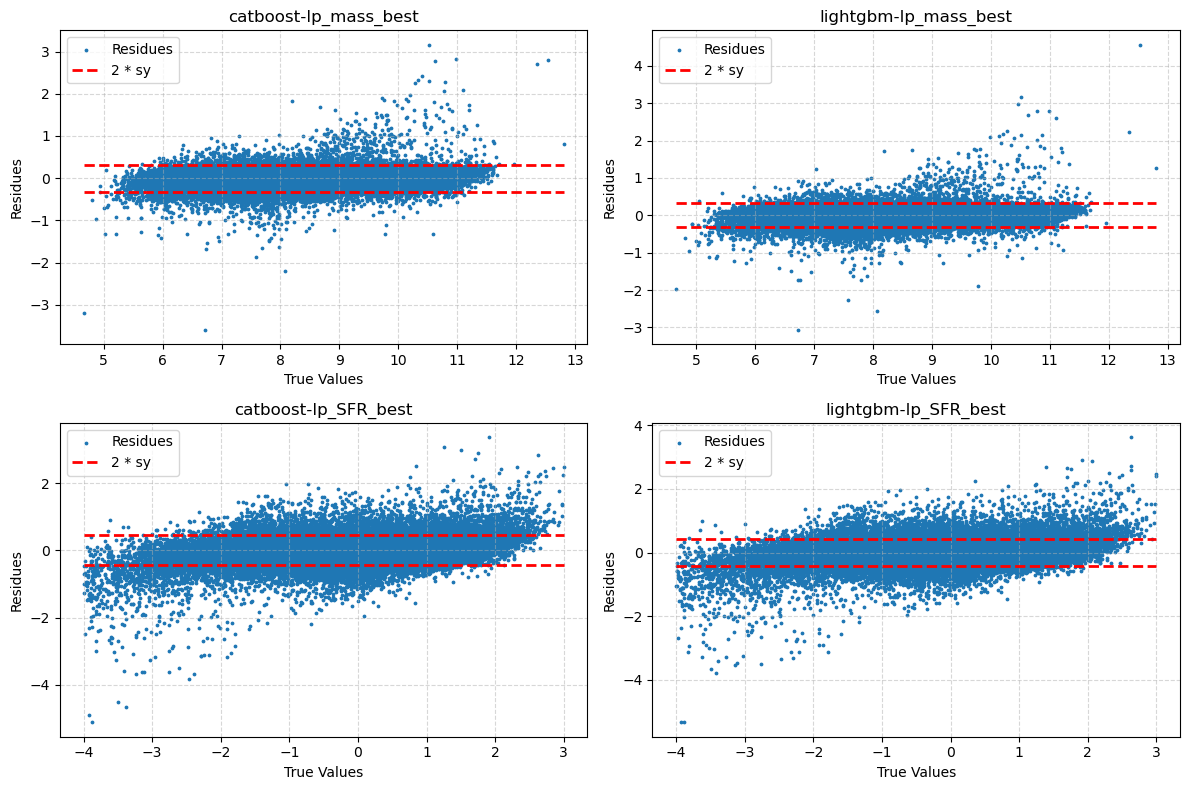

In [14]:
fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3
        
        diff = y_val[label] - pred_df['{}_{}'.format(model, label)]
        
        axes[i, j].scatter(y_val[label], diff, s=marker_size, label='Residues')
        
        # 2*sy
        sy = np.std(np.sqrt(np.abs(y_val[label] - pred_df['{}_{}'.format(model, label)])))
        axes[i, j].hlines(2 * sy, min(y_val[label]), max(y_val[label]), color='red', linestyle='dashed', linewidth=2, label='2 * sy')
        axes[i, j].hlines(-2 * sy, min(y_val[label]), max(y_val[label]), color='red', linestyle='dashed', linewidth=2)
        
        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Residues')

        axes[i, j].legend()

plt.tight_layout()
plt.show()

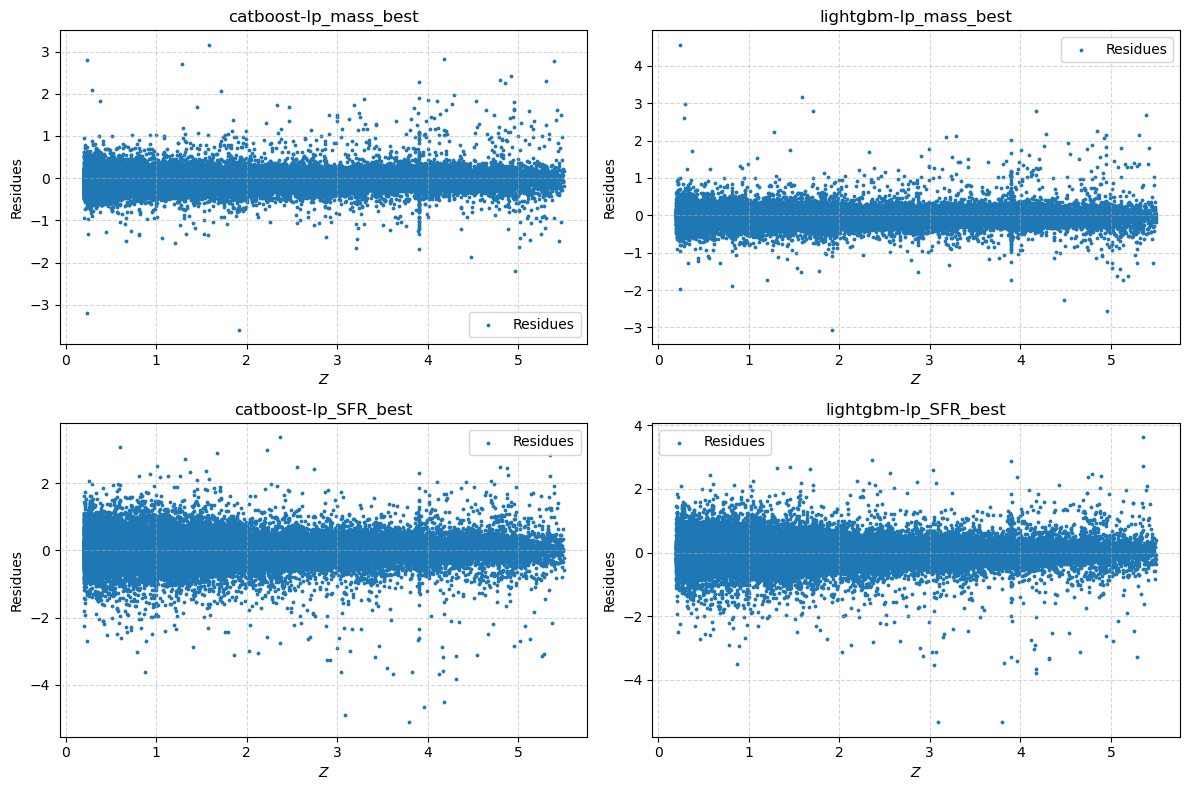

In [15]:
models = ['catboost', 'lightgbm']

fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3

        diff = y_val[label] - pred_df['{}_{}'.format(model, label)]

        axes[i, j].scatter(X_val['lp_zBEST'], diff, s=marker_size, label='Residues')

        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel(r'$Z$')
        axes[i, j].set_ylabel('Residues')

        axes[i, j].legend()

plt.tight_layout()
plt.show()

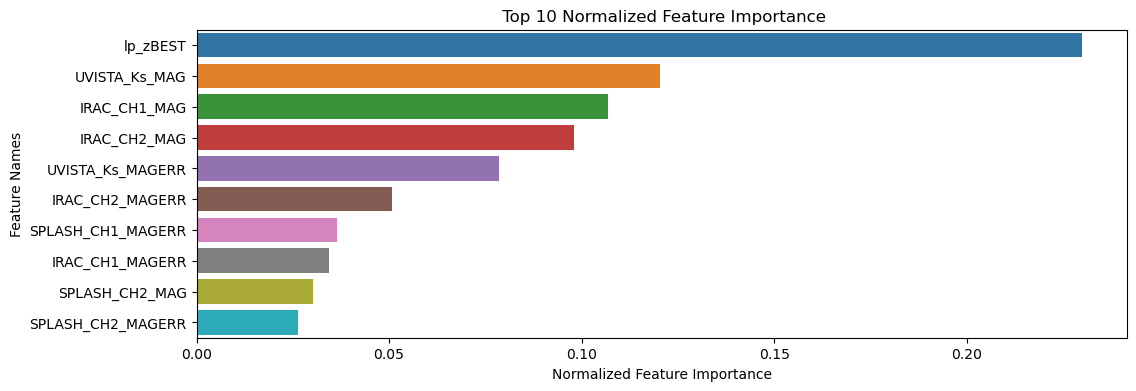

In [16]:
def plot_feature_importance(importance, names):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Normalize feature importance values
    normalized_importance = feature_importance / feature_importance.sum()

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': normalized_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Select only the top 10 features
    top_10_features = fi_df.head(10)

    # Define size of bar plot
    plt.figure(figsize=(12, 4))
    # Plot Seaborn bar chart
    sns.barplot(x=top_10_features['feature_importance'], y=top_10_features['feature_names'])
    # Add chart labels
    plt.title(' Top 10 Normalized Feature Importance')
    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature Names')

features_importances = regressor.estimators_[0].feature_importances_
names = X_train.columns

plot_feature_importance(features_importances, names)


In [17]:
def metrics(y, ŷ, outlier_threshold=0.3):
    
    f_out = np.abs(ŷ - y)
    nmad = 1.48 * np.median(f_out)
    bias = np.median(f_out)
    
    # Identify outliers
    is_outlier = f_out > outlier_threshold
    percentage_outliers = np.mean(is_outlier) * 100
    
    y_outlier = pd.Series(np.where(is_outlier, 'outlier', 'not outlier'))
    
    mse = mean_squared_error(ŷ, y)
    r2 = r2_score(y, ŷ)
    
    print(f"{y_outlier.value_counts()}")
    print(f"Percentage of values that are outliers: {percentage_outliers:.2f}%\n")
    print(f"Bias: {bias:.3f}\n")
    print(f"NMAD score: {nmad:.3f}\n")
    print(f"R²= {r2:.3f}\n")
    print(f'MSE = {mse:.3f}')

In [18]:
for label in labels:
    for model in models:
        print(f'-----------{model}-{label}-------------\n')
        metrics(y_val[label],pred_df[f'{model}_{label}'])
        print('\n')

-----------catboost-lp_mass_best-------------

not outlier    53923
outlier         4101
dtype: int64
Percentage of values that are outliers: 7.07%

Bias: 0.086

NMAD score: 0.127

R²= 0.972

MSE = 0.033


-----------lightgbm-lp_mass_best-------------

not outlier    54100
outlier         3924
dtype: int64
Percentage of values that are outliers: 6.76%

Bias: 0.085

NMAD score: 0.125

R²= 0.972

MSE = 0.033


-----------catboost-lp_SFR_best-------------

not outlier    41341
outlier        16683
dtype: int64
Percentage of values that are outliers: 28.75%

Bias: 0.181

NMAD score: 0.268

R²= 0.897

MSE = 0.130


-----------lightgbm-lp_SFR_best-------------

not outlier    42017
outlier        16007
dtype: int64
Percentage of values that are outliers: 27.59%

Bias: 0.178

NMAD score: 0.263

R²= 0.902

MSE = 0.123


